<h1> Import Data </h1>

Check individual dataset files for more info about each dataframe.

In [230]:
# Import modules
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# WEIGHTLIFTING DATA ------------------------------------------------------------------------
# Import data & clean
# From: https://www.kaggle.com/datasets/piterfm/olympic-games-medals-19862018/
filePath = './Raw Data/Summer-Winter Olympics/'
fileName = 'olympic_medals.csv'
colHeads = ["discipline_title", "oly_game", "event_title", "event_gender", "medal_type", "participant_type", 
            "particpant_title", "athlete_url", "athlete_full_name", "country_name", "country_code_2_letter", "country_code"]        # column names
allSports = pd.read_csv(filePath+fileName, skiprows=1, names=colHeads)                                                              # read in all data (every sport)

# Focus exclusively on weightlifting
weightDF = allSports[allSports['discipline_title'] == 'Weightlifting']                                                              # all weightlifting medalists, by game, 1896-2022

# Trim data of labels that are redundant for our purposes
weightDF = weightDF.drop(columns=["discipline_title", "participant_type", "particpant_title", "athlete_url", 
                                  "country_code_2_letter"], axis=1)

# Add explicit year column (to help in data analysis later)
years = pd.Series(weightDF["oly_game"].str[-4:], name='year', dtype='int')                                                          # get year for each row (last four characters of 'oly_game')
weightDF = pd.concat([weightDF, years], axis=1)                                                                                     # concatenate, column-wise
# display(weightDF)


# HEALTHY DIET DATA ------------------------------------------------------------------------
# Import data & clean
# From: https://databank.worldbank.org/source/food-prices-for-nutrition
path2file = './Raw Data/Healthy Diet and Populations/'
fn = 'cost of healthy diet.csv'
colHeads = ["Classification Name", "Classification Code", "country_name", "country_code", "year", "Time Code", "population",
            "millions_healthy_diet", "millions_nutrient", "millions_calories", "percent_healthy_diet", "percent_nutrient",
            "percent_calories", "affordability_energy", "affordability_nutrient", "affordability_healthy_diet" ]
DF = pd.read_csv(path2file+fn, skiprows=1, names=colHeads, encoding='iso-8859-1') 


DFDiet = DF.drop(columns=["Classification Name", "Classification Code", "Time Code", ])  # remove unneeded columns
DFDiet = DFDiet.drop([930, 931, 932, 933, 934])                            # delete update and author info at bottom of file
DFDiet.replace('..', np.nan, inplace=True)                                 # turn invalid data ('..') into NaN for easy exclusion during analysis
# display(DFDiet)

<h1> Graph 1 with analysis </h1>

<h3> Top Medal Earning Countries, for Men's and Women's Olympic Weightlifting </h3>

Men:  1896
Women:  2000


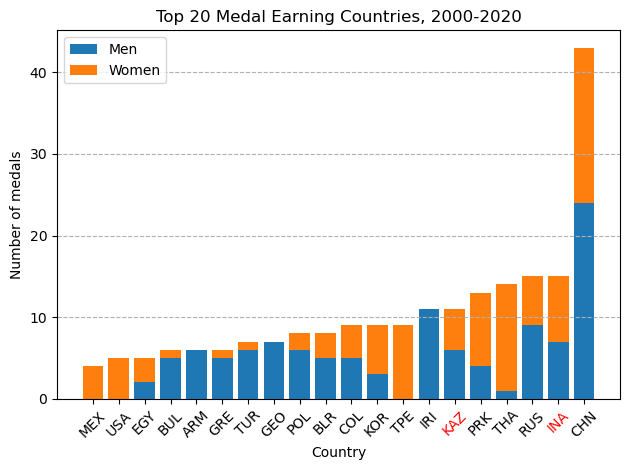

['Mexico', 'United States of America', 'Egypt', 'Bulgaria', 'Armenia', 'Greece', 'Turkey', 'Georgia', 'Poland', 'Belarus', 'Colombia', 'Republic of Korea', 'Chinese Taipei', 'Islamic Republic of Iran', 'Kazakhstan', "Democratic People's Republic of Korea", 'Thailand', 'Russian Federation', 'Indonesia', "People's Republic of China"]


In [231]:
# How far back do medals go per gender?
print("Men: ", weightDF[weightDF.event_gender == "Men"].year.min())
print("Women: ", weightDF[weightDF.event_gender == "Women"].year.min())

# We notice that men have weightlifting medals going back to 1896, but 
# women only have medals going back to 2000 (when Women's Olympic lifting was formally introduced).


# Look at 21st Century lifting medals, and plot top 10 medal earning countries (specify event gender per medal won)
twenty1stDF = weightDF[weightDF.year >= 2000]                                   # data from 2000 to 2020
countries, counts = np.unique(twenty1stDF.country_code, return_counts=True)
countIndices = np.argsort(counts)                                               # sort counts in ascending order
topResults = countIndices[-20:]                                                 # get indices of top 20 counts


# Get data by gender, for each country
topResultsNames = []                                                # hold country names for top results
topWomen = np.empty(len(topResults))                                # hold results for women, per country
topMen = np.empty(len(topResults))                                  # hold results for men, per country
halfFlag = np.zeros(len(topResults))                                # hold flag for all countries with roughly equal distribution of men and women's medals

for i in range(len(topResults)):  
    cName = countries[topResults[i]]                                          
    topResultsNames.append(cName)                                                       # store names of countries in top results
    topWomen[i] = twenty1stDF[ (twenty1stDF.country_code == cName)
                              & (twenty1stDF.event_gender == "Women")].shape[0]         # get number of women's medals for this country, 2000-2020
    topMen[i] = twenty1stDF[ (twenty1stDF.country_code == cName)
                              & (twenty1stDF.event_gender == "Men")].shape[0]           # get number of men's medals for this country, 2000-2020
    tempFlag = topWomen[i] / (topWomen[i] + topMen[i])
    if((tempFlag >= 0.45) & (tempFlag <= 0.55)): halfFlag[i] = 1                        # if 45-55% of medals are from women, flag this country

# Plot data as stacked bar chart
bottoms = np.zeros(len(topResults))                                                  # bottoms for stacked bar plot
plt.bar(topResultsNames, topMen, label="Men", bottom=bottoms, color='tab:blue')
bottoms += topMen                                                                    # adjust bottoms to begin where men's data ended
plt.bar(topResultsNames, topWomen, label="Women", bottom=bottoms, color='tab:orange')

for i in range (len(topResults)):                                                    # set label to different color for countries with roughly 50/50 across gender for medals
    if halfFlag[i] == 1: plt.gca().get_xticklabels()[i].set_color('red')            


# Graph settings
plt.title("Top 20 Medal Earning Countries, 2000-2020")
plt.xlabel("Country")
plt.ylabel("Number of medals")
plt.grid(axis='y', linestyle='dashed')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.legend()
plt.show()


# Get full name for each country
names = []
for i in range(len(topResults)):  
    code = countries[topResults[i]]
    name = twenty1stDF[twenty1stDF.country_code == code].country_name.values[0]
    names.append(name)       
print(names)

### From this graph we can see a few points of interest:

1) No countries except for China have more than 20 medals (China has 40+ medals in the 2000-2020 period) and only six other countries have more than 10 medals total for this time period. All other countries who were top medal earners got less than 10 medals for this period

2) Regarding gender, there are a few topics of interest in the graph. Only two countries from the data were flagged (red label) for having a roughly equal distribution of medals across genders (45-55% distribution to be exact), implying that among the top 20 medal earners for 2000 through 2020, there is a gender bias across medal earners per country. Every other country fell within one of three categories: all one gender, more women, or more men. The majority of top medal earning countries fall within the more medals earned by men (these countries most likely have gender roles that make weightlifting more open to men, but not women), but interestingly there are some countries where the gender distribution is skewed entirely toward one gender. For example, Iran has all of its medals earned by men in this period, while Taiwan, the US, and Mexico have all medals earned by women in this time frame. 

3) Six of the top medal earners in the graph were previously the Soviet Union (Russian Federation), or one of its satellite states (Bulgaria, Armenia, Georgia, Belarus, and Kazakhstan). This could potential arise from Soviet Era interest in weightlifting and Olympics in general, where the USSR wanted to outperform the West in the Olympics to showcase their own cultural/athletic significance on a global scale during the Cold War. The USSR may no longer be around anymore, but a tradition of training for the Olympics and interest in it could still remain, pushing greater investment into atheltes from these countries by their governments.

<h1> Graph 2 with analysis </h1>

<h3>  Medals earned by country from 2000-2020, contrasted with percent of population that cannot afford a healthy diet. </h3>

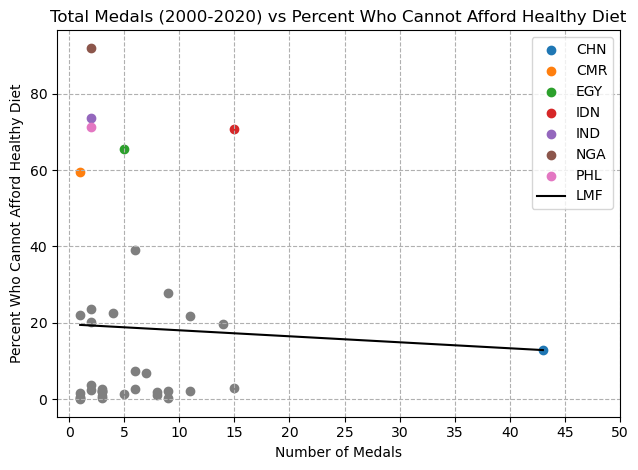

CHN = China
CMR = Cameroon
EGY = Egypt, Arab Rep.
IDN = Indonesia
IND = India
NGA = Nigeria
PHL = Philippines


In [232]:
# Note: Chose 2000-2020 range to avoid extrapolation regarding data from other dataset, since healthy diet data only goes from 2017-2021.
#   Hence percent who cannot afford a healthy diet, is an average across 2017-2021 for each country.

DFDiet.percent_healthy_diet = pd.to_numeric(DFDiet.percent_healthy_diet)        # convert data type of this column to be numeric and not a string/object
twenty1stDF = weightDF[weightDF.year >= 2000]                                   # data from 2000 to 2020

cCodes = np.unique(twenty1stDF.country_code)                                    # name of each country that earned medals, 2000-2020
# Country codes are not standardized across the data sets, must adjust
dietCodes = ['ARM', 'AZE', 'BLR', 'BGR', 'CAN', 'CHN', 'CMR', 'COL', 'HRV', 'CUB', 'DOM', 'ECU',
            'EGY', 'ESP', 'FRA', 'GBR', 'GEO', 'DEU', 'GRC', 'HUN', 'IDN', 'IND', 'IRN', 'ITA',
            'JPN', 'KAZ', 'KOR', 'LVA', 'LTU', 'MEX', 'NGA', 'PHL', 'POL', 'PRK', 'QAT', 'RUS',
            'SAM', 'SYR', 'THA', 'TKM', 'TWN', 'TUR', 'UKR', 'USA', 'UZB', 'VEN', 'VNM']
# No equivalents in diet data: Cuba (CUB), Georgia (GEO), North Korea (PRK), Samoa (SAM), Syria, (SYR), 
#                               Turkimenistan (TKM), Ukraine (UKR), Uzbekistan (UZB), Venezula (VEN). 

# Find values without equavalencies across datasets, then exclude them. Qatar ("QAT") is present in both datasets, but has no values for var we are observing in DietDF
exclude = ["CUB", "GEO", "PRK", "SAM", "SYR", "TKM", "UKR", "UZB", "VEN", "QAT"]
excludeIdx = []
for i in range(len(dietCodes)):                     # find every index of values we wish to exclude and add to index list
    code = dietCodes[i]
    if code in exclude:
        excludeIdx.append(i)

# Remove 'exclude' values from both sets of codes
cCodes = np.delete(cCodes, excludeIdx)
dietCodes = np.delete(dietCodes, excludeIdx)

# Arrays for data per country
numMedals = np.zeros(len(cCodes))
percentAvgs = np.zeros(len(cCodes))

# Get data for each country, then plot it
for i in range(len(cCodes)):
    # Get total medals earned per country for this time frame
    country = cCodes[i]
    num = twenty1stDF[twenty1stDF.country_code == country].shape[0]        # get num rows (num medals) earned for this country in this time period
    numMedals[i] = num
    
    # Get averages for percent of pop that cannot afford a healthy diet, for each country
    country = dietCodes[i]
    avg = np.nanmean(DFDiet[DFDiet.country_code == country].percent_healthy_diet.values)
    percentAvgs[i] = avg

    # Plot this country, with some conditions to highlight high values
    if((avg > 58) | (num > 40)):
        plt.scatter(num, avg, label=country)
    else:
        plt.scatter(num, avg, color='tab:gray')


# Fit a model
y = percentAvgs/len(cCodes)
coeff = np.polyfit(numMedals, percentAvgs, 1)                           # get coefficients of polynomial
polyFunc = np.poly1d(coeff)                                             # create polynomial using coefficients from polyfit()  
xdata = np.linspace(np.min(numMedals), np.max(numMedals), 1000)         # xdata for linear model fit
ydata = polyFunc(xdata)                                                 # ydata for linear model fit

plt.plot(xdata, ydata, color='black', label='LMF')                      # plot linear model fit


# Graph settings
plt.title("Total Medals (2000-2020) vs Percent Who Cannot Afford Healthy Diet")
plt.xlabel("Number of Medals")
plt.ylabel("Percent Who Cannot Afford Healthy Diet")
plt.tight_layout()
plt.xticks(np.arange(0,51,5))
plt.grid(linestyle='dashed')
plt.legend()
plt.show()

# Get names of each highlighted country and print
graphCodes = ["CHN", "CMR", "EGY", "IDN", "IND", "NGA", "PHL"]
for code in graphCodes:
    name = DFDiet[DFDiet.country_code == code].country_name.values[0]
    print(code, " = ", name, sep='')

### Discussion:

1) Even though a few countries from the weightlifting Olympics dataset had no data in the healthy diet dataframe, the majority of countries that were plotted for this time period had less than 30% who could not afford a healthy diet in the country. Many of the points even in this subcategory were 10% or lower on population who could not afford a healthy diet. Almost every country (except for China) in the bracket of 30% or lower had somewhere between one to 15 medals earned, and there appears to be a trend toward countries with a lower percent of the population being unable to afford a healthy diet, and higher medals, though there are some outliers. For example, Indonesia has roughtly 15 medals for this period, but the average percent who could not afford a healthy diet was about 70%. The linear model fit line also implies this trend, since it has a very gradual decrease in slope as the number of medals increases.

2) From the data, six countries who earned medals in this period had a percent of population who could not afford a healhty diet, of 58% or greater. This could potentially be that Olympic weightlifting (or sports in general) is state supported in these countries, with athletes recieving some sort of support from the government to train. This also highlights how some countries grapple with poverty and hunger at the same time as some citizens are prosperous enough to train and go to the Olympics.

3) There are two outliers on opposite extremes of the scatter plot. One is Nigeria with about 3 medals earned in the 2000-2020 time frame, but an average percent of population who could not afford a healthy diet at about 90%. This implies that either weightlifters in Nigeria are better off than the rest of the population of their country or well supported by their government, since much of the rest of country is unable to afford a sufficent diet. The other outlier is China which has been identified in the previous graph, with almost 45 medals for this time period and about 15% of the population is unable to afford a healthy diet. This percentage is much lower than Nigeria and a few others, but is still not insignificant, this may come from the fact that China has a very large population, most likely with many living under vastly different circumstances across the country. The high number of medals recorded in the dataset indicates a potentially high interest in Olympic weightlifting by Chinese citizens, or the Chinese government providing great support to weightlifers in the country as a way to showcase their atheltic and cultural prowess through the Olympics, maybe in an attempt to build international 'soft power.' 

<h1> Graph 3 with analysis </h1>

<h3> Does population effect total number of medals a country earns? In other words, would you expect a higher population country to have a higher number of Olympic weightlifting medals? </h3>